赛题分析：可知是离散的分类问题
预测在此次沉船事故中哪些人存活的可能性比较大

In [1869]:
import warnings
warnings.filterwarnings('ignore')
# 计算库
import numpy as np
import pandas as pd

# 从sklearn中引入一些算法库
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelling Helpers
from sklearn import preprocessing
from sklearn.preprocessing import Imputer, Normalizer, scale
# 交叉验证
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV

# 可视化
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams[ 'figure.figsize' ] = 8 , 6


In [1870]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [1871]:
# 加载数据
root_path = './data/'
# train = pd.read_csv('%s%s' % (root_path, 'train.csv'), header = 0, dtype={'Age': np.float64})
# test = pd.read_csv('%s%s' % (root_path, 'test.csv'), header = 0, dtype={'Age': np.float64})
# train = pd.read_csv('train.csv', header = 0, dtype={'Age': np.float64})
# test  = pd.read_csv('test.csv' , header = 0, dtype={'Age': np.float64})
train = pd.read_csv('%s%s' % (root_path, 'train.csv'))
test = pd.read_csv('%s%s' % (root_path, 'test.csv'))
print len(train)
print len(test)
# 全部数据 train+test
full = train.append(test, ignore_index=True)
# 训练数据
titanic = full[:891]
# del test, train
print ('Datasets: ', 'full: ', full.shape, 'titanic: ', titanic.shape)

891
418
('Datasets: ', 'full: ', (1309, 12), 'titanic: ', (891, 12))


In [1872]:
full.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [1873]:
full.tail(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


In [1874]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


从上述info信息可以看到Age（714）和Cabin（204）两个特征有较多的数据缺失，这两块数据后面需要特殊处理一下

首先第一步要做的是特征分析，分析上述训练集中各个特征和预测结果之间的关系，对预测结果的影响，然后才能决定采取什么样的特征处理方法。变量描述如下：

Survived: Survived (1) or died (0)  是否存活 1 存活  0 死亡
Pclass: Passenger's class 舱位等级
Name: Passenger's name 乘客的名字
Sex: Passenger's sex  乘客的性别
Age: Passenger's age  乘客的年龄
SibSp: Number of siblings/spouses aboard  登船的兄弟姐妹数
Parch: Number of parents/children aboard  登船的父母子女数
Ticket: Ticket number 票号
Fare: Fare  票价
Cabin: Cabin  船舱
Embarked: Port of embarkation 登船港口

In [1875]:
titanic.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


为了帮助我们更好的理解哪个变量更为重要，接下来绘制一下热力分布图：

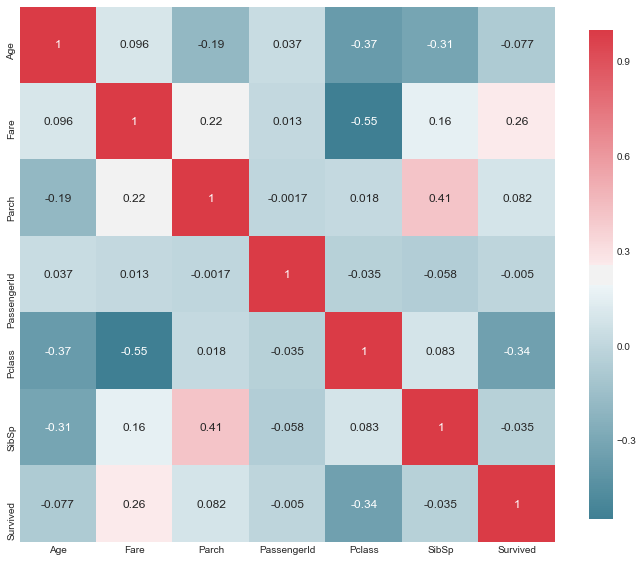

In [1876]:
plot_correlation_map(titanic)

上图只是粗略从任意两个变量之间的相关性来查看，接下来进一步分别对每个变量分析一下跟存活下来的关系：
年龄跟存活的关系：

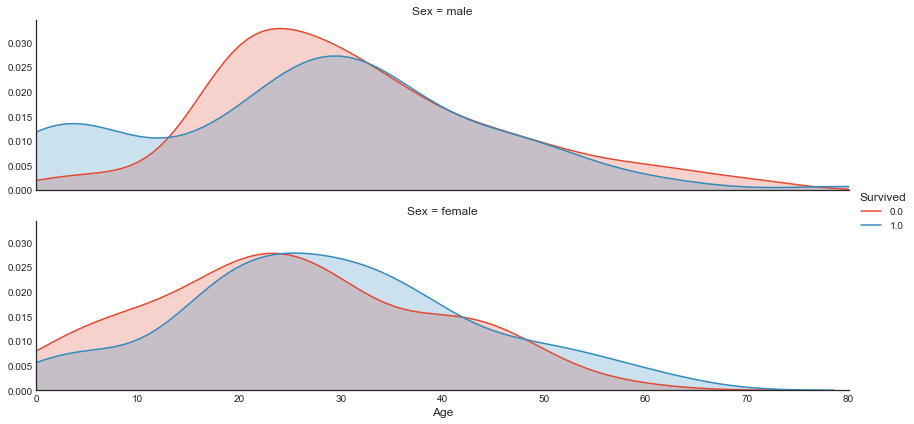

In [1877]:
plot_distribution(titanic, var='Age', target='Survived', row='Sex')

对于男性25岁左右存活率较低，10岁以下的小孩存活率较高；而女性在30岁左右的存活率则较高，50岁以后的老人存活率也较高

10岁左右的小女孩和60岁左右的男性老人的存活率较低

Fare(票价)  数据中可以看到票价居然各不相同，而且存在n多种，这似乎不太符合传统的认知，票价不应该只有确定的几种吗【不管了，可能当时老外的船票就是因人而异，看心情定价咯】 因此需要做一下处理，可以分成几个价格区间来分析

  CategoricalFare  Survived
0       [0, 7.91]  0.197309
1  (7.91, 14.454]  0.303571
2    (14.454, 31]  0.454955
3   (31, 512.329]  0.581081


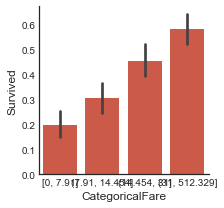

In [1878]:
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())
plot_categories(train, cat='CategoricalFare', target='Survived')

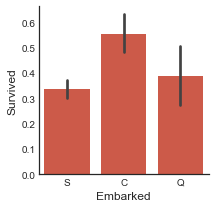

In [1879]:
plot_categories(titanic, cat='Embarked', target='Survived')
# 登船港口也会影响存活率，猜测可能是不同的登船口人员不同，但是这块不好说有一定的必然联系

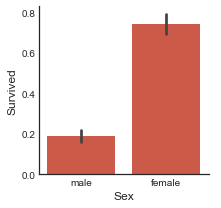

In [1880]:
plot_categories(titanic, cat='Sex', target='Survived')
# 女性的存活率要远高于男性

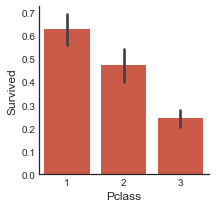

In [1881]:
plot_categories(titanic, cat='Pclass', target='Survived')
# 乘客层级越高存活率也相对较高

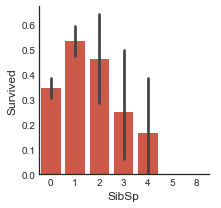

In [1882]:
plot_categories(titanic, cat='SibSp', target='Survived')
# 兄弟姐妹数较多的存活率较低

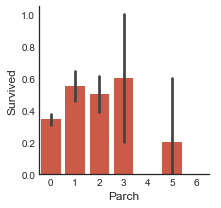

In [1883]:
plot_categories(titanic, cat='Parch', target='Survived')
# 完全没有父母子女或者父母子女人数较多的存活率偏低，这点也是符合人情的，毕竟独自一人的无依无靠，无所牵挂；父母子女多的如果自己遇难，
# 家人也还有机会被其他亲人照顾

确定性的或非数字型的变量需要转换成数字型的，包括Embarked, Pclass and Sex。

In [1884]:
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )
sex.head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

In [1885]:
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [1886]:
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


船票编号Ticket应该是出票系统的一个唯一id，可以理解为对于预测结果没有影响，暂时不做考虑。

这里来处理缺失数据：Age和Cabin。一般数据缺失对于结果的预测影响还是蛮大的，尤其是一些关键性变量数据的大量缺失，针对这种情况就需要采用一些方法去补全数据。
对于Cabin船舱号，正常情况下如果属于正常购票登船应该是有舱号记录的，但是将近80%的缺失率有点高，这种逃票的可能性不大。粗粒度处理的话就直接将是否存在舱号作为分类来分析下对存活的影响，但是不一定靠谱。
对于数据缺失率较高的的变量一般为了避免引入噪音，会选择直接丢弃掉；对于缺失量适中，数值非连续性的，比如像Cabin，可以将其中的NaN作为一个新的类别；而对于连续性的数值，最好给定一个步长进行数据的离散化或者做一下数据拟合。
这里简单采用平均值去填充数据

In [1887]:
Survived_cabin = titanic.Survived[pd.notnull(titanic.Cabin)].value_counts()
Survived_nocabin = titanic.Survived[pd.isnull(titanic.Cabin)].value_counts()
df=pd.DataFrame({u'有':Survived_cabin, u'无':Survived_nocabin}).transpose()
df.head()

,0.0,1.0
无,481,206
有,68,136


In [1888]:
def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = 1
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = 0
    return df
set_Cabin_type(titanic)
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,1,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,1,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [1889]:
imputed = pd.DataFrame()

imputed['Age'] = titanic.Age.fillna(titanic.Age.mean)
imputed.head()

,Age
0,22
1,38
2,26
3,35
4,35


性别年龄都已经有了，名字字段其实对预测结果没有太大意义了，name字段也不做参考【万万没想到，那时候的老外名字的姓氏居然包含着地位信息。。。】

In [1890]:
# Feature Selection 特征工程选择，去掉Name特征
drop_elements = ['Name']
titanic = titanic.drop(drop_elements, axis = 1)

drop_elements = ['Ticket']
titanic = titanic.drop(drop_elements, axis = 1)

# drop_elements = ['PassengerId']
# titanic = titanic.drop(drop_elements, axis = 1)

def set_Embarked_type(df):
    df.loc[ (df.Embarked == 'C'), 'Embarked' ] = 1
    df.loc[ (df.Embarked == 'Q'), 'Embarked' ] = 2
    df.loc[ (df.Embarked == 'S'), 'Embarked' ] = 3
    return df
set_Embarked_type(titanic)

def set_Sex_type(df):
    df.loc[ (df.Sex == 'male'), 'Sex' ] = 0
    df.loc[ (df.Sex == 'female'), 'Sex' ] = 1
    return df
set_Sex_type(titanic)

def set_Age_type(df):
    df.loc[ (df.Age.isnull()), 'Age' ] = df.Age.mean()
set_Age_type(titanic)

titanic.head(10)
# test = test.drop(drop_elements, axis=1)
# test.head(5)

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.000000,0,3,7.2500,0,1,3,0,1,0.0
1,38.000000,1,1,71.2833,0,2,1,1,1,1.0
2,26.000000,0,3,7.9250,0,3,3,1,0,1.0
3,35.000000,1,3,53.1000,0,4,1,1,1,1.0
4,35.000000,0,3,8.0500,0,5,3,0,0,0.0
5,29.699118,0,2,8.4583,0,6,3,0,0,0.0
6,54.000000,1,3,51.8625,0,7,1,0,0,0.0
7,2.000000,0,3,21.0750,1,8,3,0,3,0.0
8,27.000000,0,3,11.1333,2,9,3,1,0,1.0
9,14.000000,0,1,30.0708,0,10,2,1,1,1.0


逻辑回归建模，需要输入的特征是数值型的，这里一般会有一个特征因子化的处理。简单说就是一个维度横向扩展为多个维度，采用0和1来表示，接下来举例来说明：

In [1891]:
dummiesEmbarked = pd.get_dummies(titanic.Embarked, prefix='Embarked')
dummiesCabin = pd.get_dummies(titanic.Cabin, prefix='Cabin')
dummiesSex = pd.get_dummies(titanic.Sex, prefix='Sex')
# dummiesParch = pd.get_dummies(titanic.Parch, prefix='Parch')
dummiesPclass = pd.get_dummies(titanic.Pclass, prefix='Pclass')

df = pd.concat([titanic, dummiesCabin, dummiesEmbarked, dummiesPclass, dummiesSex], axis=1)
df.drop(['Pclass', 'Parch', 'Sex', 'Cabin', 'Embarked', 'SibSp'], axis=1, inplace=True)
df.head()

,Age,Fare,PassengerId,Survived,Cabin_0,Cabin_1,Embarked_1,Embarked_2,Embarked_3,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1
0,22.0,7.2500,1,0.0,1,0,0,0,1,0,0,1,1,0
1,38.0,71.2833,2,1.0,0,1,1,0,0,1,0,0,0,1
2,26.0,7.9250,3,1.0,1,0,0,0,1,0,0,1,0,1
3,35.0,53.1000,4,1.0,0,1,0,0,1,1,0,0,0,1
4,35.0,8.0500,5,0.0,1,0,0,0,1,0,0,1,1,0


查看Age和Fare两列数据可以看到，乘客的数值幅度变化太大，会影响收敛，需要做归一化处理，归一化到[-1,1]

In [1892]:
scaler = preprocessing.StandardScaler()
# std_scale = preprocessing.StandardScaler().fit(df[['Age', 'Fare']])
# df[['Age', 'Fare']] = std_scale.transform(df[['Age', 'Fare']])
df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])
df.head()

,Age,Fare,PassengerId,Survived,Cabin_0,Cabin_1,Embarked_1,Embarked_2,Embarked_3,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1
0,-0.592481,-0.502445,1,0.0,1,0,0,0,1,0,0,1,1,0
1,0.638789,0.786845,2,1.0,0,1,1,0,0,1,0,0,0,1
2,-0.284663,-0.488854,3,1.0,1,0,0,0,1,0,0,1,0,1
3,0.407926,0.420730,4,1.0,0,1,0,0,1,1,0,0,0,1
4,0.407926,-0.486337,5,0.0,1,0,0,0,1,0,0,1,1,0


In [1893]:
train_df = df.filter(regex='Survived|Age|Fare|Cabin_*|Embarked_*|Pclass_*|Sex_*')
train_np = train_df.as_matrix()

train_df.head()
# 获取输出 Survived
y = train_np[:, 2]
# 获取训练数据
drop_elements = ['Survived']
temp = train_df.drop(drop_elements, axis = 1)
X = temp.as_matrix()[:, :]

clf = LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
clf.fit(X, y)
clf


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

In [1894]:
imputed = pd.DataFrame()

imputed['Age'] = test.Age.fillna(test.Age.mean)
# imputed['Fare'] = test.Fare.fillna(test.Fare.mean)
imputed.head()

,Age
0,34.5
1,47
2,62
3,27
4,22


In [1895]:
def testFareNull(df):
    if df.Fare.empty:
        print df.Fare
testFareNull(test)

# np.isfinite(df.Fare)
# 无缺失值
np.isnan(df.Fare.any())
np.where(df.Fare >= np.finfo(np.float64).max)

(array([], dtype=int64),)

In [1896]:
drop_elements = ['Name']
test = test.drop(drop_elements, axis = 1)

drop_elements = ['Ticket']
test = test.drop(drop_elements, axis = 1)

# drop_elements = ['PassengerId']
# test = test.drop(drop_elements, axis = 1)

def set_Embarked_type(df):
    df.loc[ (df.Embarked == 'C'), 'Embarked' ] = 1
    df.loc[ (df.Embarked == 'Q'), 'Embarked' ] = 2
    df.loc[ (df.Embarked == 'S'), 'Embarked' ] = 3
    return df
set_Embarked_type(test)

def set_Sex_type(df):
    df.loc[ (df.Sex == 'male'), 'Sex' ] = 0
    df.loc[ (df.Sex == 'female'), 'Sex' ] = 1
    return df
set_Sex_type(test)

def set_Age_type(df):
    df.loc[ (df.Age.isnull()), 'Age' ] = df.Age.mean()
set_Age_type(test)

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = 1
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = 0
    return df
set_Cabin_type(test)

# test
# 维度扩展
dummiesEmbarked = pd.get_dummies(test.Embarked, prefix='Embarked')
dummiesCabin = pd.get_dummies(test.Cabin, prefix='Cabin')
dummiesSex = pd.get_dummies(test.Sex, prefix='Sex')
# dummiesParch = pd.get_dummies(titanic.Parch, prefix='Parch')
dummiesPclass = pd.get_dummies(test.Pclass, prefix='Pclass')

df_test = pd.concat([test, dummiesCabin, dummiesEmbarked, dummiesPclass, dummiesSex], axis=1)
df_test.drop(['Pclass', 'Parch', 'Sex', 'Cabin', 'Embarked', 'SibSp'], axis=1, inplace=True)
df_test

np.isnan(df_test.any())


df_test.tail()
# Age和Fare归一化
scaler = preprocessing.StandardScaler()
df_test[['Age', 'Fare']]
# 删除测试集合中为空的行
df_test.dropna(inplace=True)
# 发现存在一行有缺失值
len(df_test)  
df_test[['Age', 'Fare']] = scaler.fit_transform(df_test[['Age', 'Fare']])
df_test.head()


,PassengerId,Age,Fare,Cabin_0,Cabin_1,Embarked_1,Embarked_2,Embarked_3,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1
0,892,0.342695,-0.497811,1,0,0,1,0,0,0,1,1,0
1,893,1.338924,-0.512660,1,0,0,0,1,0,0,1,0,1
2,894,2.534399,-0.464532,1,0,0,1,0,0,1,0,1,0
3,895,-0.255043,-0.482888,1,0,0,0,1,0,0,1,1,0
4,896,-0.653535,-0.417971,1,0,0,0,1,0,0,1,0,1


In [1897]:
pred_test = df_test.filter(regex='Survived|Age|Fare|Cabin_*|Embarked_*|Pclass_*|Sex_*')
predictions = clf.predict(pred_test)
predictions
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.head(10)
result.to_csv("./logistic_regression_predictions.csv", index=False)

In [1898]:
from sklearn import cross_validation #简单看看打分情况
clf = LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
all_data = df.filter(regex='Survived|Age|Fare|Cabin_*|Embarked_*|Pclass_*|Sex_*')
all_data.head()

train_np = all_data.as_matrix()
# 获取输出 Survived
y = train_np[:, 2]
# 获取训练数据
drop_elements = ['Survived']
temp = all_data.drop(drop_elements, axis = 1)
X = temp.as_matrix()[:, :]

# X = all_data.as_matrix()[:,1:]
# y = all_data.as_matrix()[:,0]
print cross_validation.cross_val_score(clf, X, y, cv=5)

[ 0.80446927  0.79888268  0.80337079  0.7752809   0.81355932]


In [1905]:
# 由于测试集本身没有存活的结果，所以这里做交叉验证，拆分训练集数据，随机30%的数据作为测试集，其余70%数据用来训练模型做预测
split_train, split_cv = cross_validation.train_test_split(df, test_size=0.3, random_state=0)
train_df = split_train.filter(regex='Survived|Age|Fare|Cabin_*|Embarked_*|Pclass_*|Sex_*')# 生成模型
clf = LogisticRegression(C=1.0, penalty='l2', tol=1e-6)

train_np = train_df.as_matrix()
# 获取输出 Survived
y = train_np[:, 2]
# 获取训练数据
drop_elements = ['Survived']
temp = train_df.drop(drop_elements, axis = 1)
X = temp.as_matrix()[:, :]
clf.fit(X, y)# 对cross validation数据进行预测

cv_df = split_cv.filter(regex='Survived|Age|Fare|Cabin_*|Embarked_*|Pclass_*|Sex_*')

cv_df.head(20)

train_np = cv_df.as_matrix()
# 获取训练数据
drop_elements = ['Survived']
temp = cv_df.drop(drop_elements, axis = 1)
X_cv = temp.as_matrix()[:, :]
predictions = clf.predict(X_cv)

predictions

origin_data_train = pd.read_csv('%s%s' % (root_path, 'train.csv'))
origin_data_train.head()
split_cv.head()
bad_cases = origin_data_train.loc[origin_data_train['PassengerId'].isin(split_cv[predictions != cv_df.as_matrix()[:,2]]['PassengerId'].values)]
bad_cases
# len(bad_cases)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.00,0,0,350406,7.8542,NaN,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.00,1,0,349237,17.8000,NaN,S
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.00,5,2,CA 2144,46.9000,NaN,S
79,80,1,3,"Dowdell, Miss. Elizabeth",female,30.00,0,0,364516,12.4750,NaN,S
85,86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.00,3,0,3101278,15.8500,NaN,S
113,114,0,3,"Jussila, Miss. Katriina",female,20.00,1,0,4136,9.8250,NaN,S
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C


接下来绘制学习曲线（learning curve）来判断学习算法是过拟合还是欠拟合

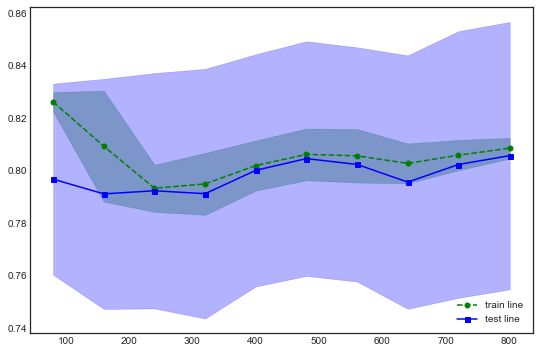

In [1915]:
from sklearn.learning_curve import learning_curve
from sklearn.metrics import f1_score, make_scorer
scaler = preprocessing.StandardScaler()
estimator = LogisticRegression(C=1.0, penalty='l2', fit_intercept=True)

f1 = make_scorer(f1_score)
all_data = df.filter(regex='Survived|Age|Fare|Cabin_*|Embarked_*|Pclass_*|Sex_*')
all_data.head()

index = range(len(all_data))
random.shuffle(index)

train_np = all_data.as_matrix()
# 获取输出 Survived
learn_y = train_np[:, 2]
# 获取训练数据
drop_elements = ['Survived']
temp = all_data.drop(drop_elements, axis = 1)
learn_X = temp.as_matrix()[:, :]

random_X = learn_X[index, :]
random_y = learn_y[index]
# train_sizes参数控制产生学习曲线的训练样本的绝对/相对数量，此处，我们设置的train_sizes=np.linspace(0.1, 1.0, 10)，
# 将训练集大小划分为10个相等的区间。learn_curve默认使用分层k折交叉验证用来计算交叉验证的准确率。cv设置k值
train_size, train_scores, test_scores = learning_curve(estimator, X=random_X, y=random_y,
                                                       train_sizes=np.linspace(0.1, 1.0, 10), cv=10, 
                                                       scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

ax.plot(train_size, train_mean, linestyle='--', color="green", marker='o', markersize=5,label="train line")
ax.fill_between(train_size, train_mean+train_std, train_mean-train_std, alpha=0.3, color="green")

ax.plot(train_size, test_mean, linestyle='-', marker='s', markersize=5, color="blue", label="test line")
ax.fill_between(train_size, test_mean+test_std, test_mean-test_std, alpha=0.3, color="blue")

plt.legend(loc="lower right")
plt.show()

可以看出测试曲线和训练曲线基本重合，误差较小，所以我们目前的模型不存在过拟合和欠拟合的情况，效果还是不错的
如果出现过拟合或欠拟合的情况，我们可以采用验证曲线来解决

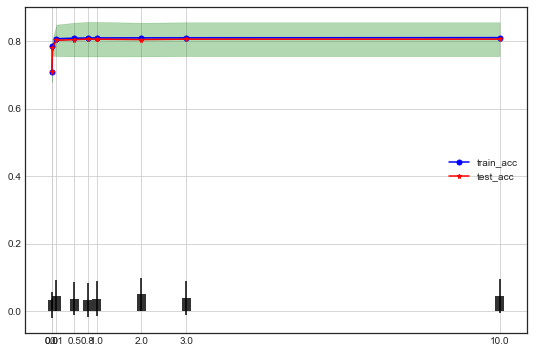

In [1917]:
param_c = [0.001, 0.01, 0.1, 0.5, 0.8, 1, 2, 3, 10]
train_scores, test_scores = validation_curve(estimator, X=random_X, y=random_y, param_name='C', param_range=param_c, cv=10, 
                 scoring='accuracy')
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

ax.plot(param_c, train_mean, marker='o', markersize=5, color='blue', label="train_acc")
ax.fill_between(param_c, train_mean+train_std, train_mean-train_std, color='blue', alpha=0.3)

ax.plot(param_c, test_mean, marker='*', markersize=5, color='red', label="test_acc")
ax.fill_between(param_c, test_mean+test_std, test_mean-test_std, color='green', alpha=0.3)
plt.bar(left=param_c, height=10*(train_mean-test_mean), width=0.2, 
        color='0.2', yerr=test_std, align='center')

plt.xticks(map(lambda x: round(x, 1), param_c))
plt.grid()
plt.legend(loc="center right")
plt.show()

由于本身模型拟合数据较好，不存在过拟合和欠拟合的情形，所以在采用验证曲线去优化拟合的两种问题时看不到明显的效果